Group 7 Opti project:  

> The scenario of our project is that we want to start a small food delivery business within SUTD, with our 4 members as the riders  
- The goal of the project is to minimize the number of drivers we employ while fulfilling all the demand each hour   
- The demand data is obtained through a survey done by the SUTD population  
- We employ drivers by the hour



> Some possible ideas for improving the model:  
- Adding a indicator variable to model a possible condition (e.g. We have a friend who only wants to work when demand exceeds a certain level, so a fifth driver (x5) would only be available if d exceeds a certain amount)
- Adding additional constraints to model: Driver 1 & 4 don't like working with each other, so if x1 is 1, x4 cannot be 1 & vice versa


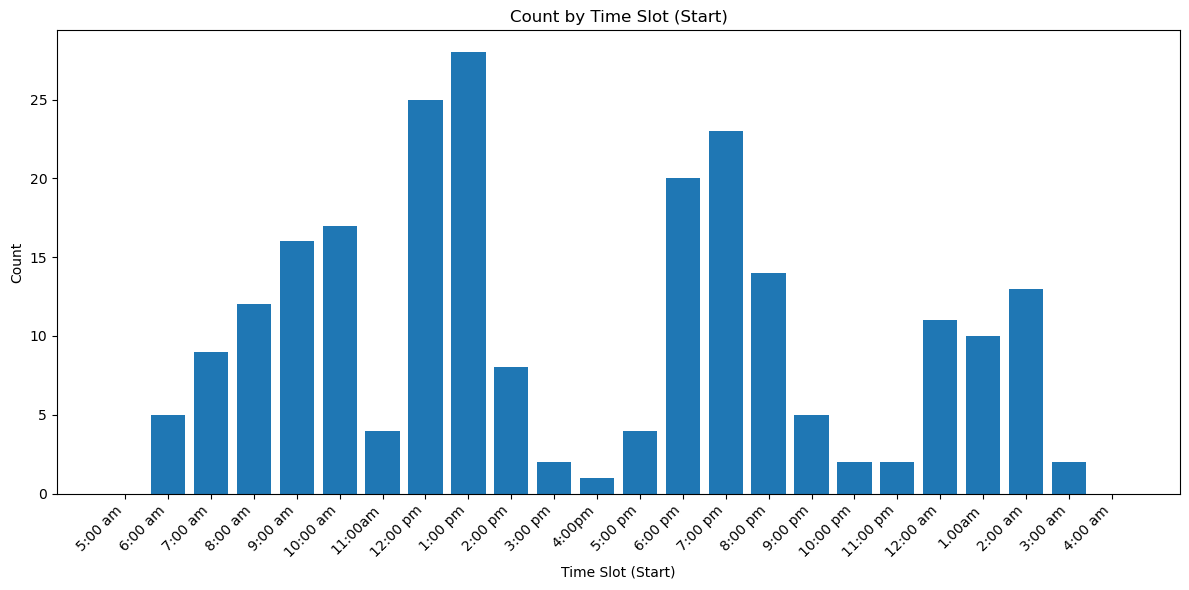

In [ ]:
# Import
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from an Excel file
df = pd.read_excel('demand_counts.xlsx') 

# Extract the hour from the Time Slot column
df['Hour'] = df['Time Slot'].str.split('-').str[0].str.strip()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(df['Hour'], df['Count'])

# Set the title and labels
plt.title('Count by Time Slot (Start)')
plt.xlabel('Time Slot (Start)')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [1]:
using MosekTools, JuMP

------START OF MODEL------   
Objective function:

In [2]:
#Start the model
m = Model(Mosek.Optimizer)
n = 4 #Number of drivers
k = 24 #Number of hours in the day
d = [11 10 13 2 0 0 5 9 12 16 17 4 25 28 8 2 1 4 20 23 14 5 2 2] # Demand in each hour

p = [3 4 2 1] # Productivity of each driver      # idea is to randomize this as an input for the driver's productivity

#Start variables
@variable(m, x[1:n,1:k], Bin) # Whether I employ driver i in hour j

#Start constraints and objective
@constraint(m, [j=1:k], sum(p[i] * x[i, j] for i in 1:n) >= d[j]) # the sum of (productivity of driver i * whether or not that driver is 
                                                                  # employed in hour i)
                                                                  # across all drivers must be more than or equals to the demand for that hour i

@objective(m, Min, sum(x[i, j] for i in 1:n, j in 1:k))
print(m)






In [3]:
optimize!(m)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : LO (linear optimization problem)
  Constraints            : 120             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 96              
  Matrix variables       : 0               
  Integer variables      : 96              

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 0.00, probing time =  0.00
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  

Objective of best integer solution : Not available.
Best objective bound               : Not available.
Initial feasible solution objective: Undefined
Construct solution objective       : Not employed
User objective cut value           : Not employed
Number of cuts generate

In [4]:
value.(x)

4×24 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [5]:
objective_value(m)

0.0

> We got bought over by a STEP student & get paid now. This scenario is now from the perspective of the owner
- The goal is to minimize total cost (Fixed & variable cost) while meeting the demand in every hour in every hotspot
- Variable cost is straight line distance, fixed cost is salary
- Every hour's total demand is split randomly into 5 "hotspots"
- The driver's and demand hotspot locations are fixed (HQ hotspots)

> Problems of model
- Problem feasibility still limited by the p vector 
- Only variable cost stops most productive driver from doing everything

In [6]:
using JuMP, MosekTools, LinearAlgebra, Random, Plots
import LinearAlgebra
import Plots
import Random


In [7]:
# Start the model
model = Model(Mosek.Optimizer)
n = 4 # Number of drivers
k = 24 # Number of hours in the day

# Productivity & energy of drivers
pr = [3 4 2 1]                                   # Still can randomize this OR draw from normal dist
fixed_c = [2]

# Helper function to randomly split an integer into n positive integers
function random_split(total::Int, n::Int)
    cuts = sort(rand(1:total-1, n-1))
    return diff([0; cuts; total])
end

random_split (generic function with 1 method)

In [8]:
d = [11 10 13 2 0 0 5 9 12 16 17 4 25 28 8 2 1 4 20 23 14 5 2 2]

d_short = filter(x -> x in partialsort(vec(d), 1:3; rev=true), vec(d))[1:3] # Automatically extract top 3 values

# Create 5 sets of x and y coordinates, to be used in my (x_c,y_c, demand) tuple
x_c = rand(5) # 5 is arbitrary to simplify the number of deliver-to locations/hotspots
y_c = rand(5)

# Random start locations for each driver
x_f = rand(n)
y_f = rand(n)

# Split demand into 15 elements, 5 x length of d_short
tuples = []
for i in 1:length(d_short)
    total_demand = d_short[i]
    demand_split = random_split(total_demand, 5)  # 5 splits for each element of d_short

    # Create 5 tuples for the current d_short value
    for j in 1:5
        push!(tuples, (x_c[j], y_c[j], demand_split[j]))
    end
end

In [9]:
c = zeros(5, n) # I'm creating a 5xn matrix. Each matrix is fixed for that hour,
                # and the rows are the order hotspots while the columns are the drivers.                  
                # Each cell is the variable cost incurred for assigning driver i to order demand hotspot j
for i in 1:5
    for j in 1:n
        c[i, j] = norm([x_c[i] - x_f[j], y_c[i] - y_f[j]])
    end
end

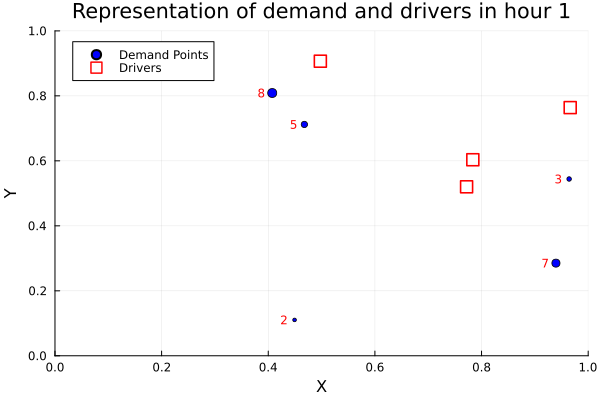

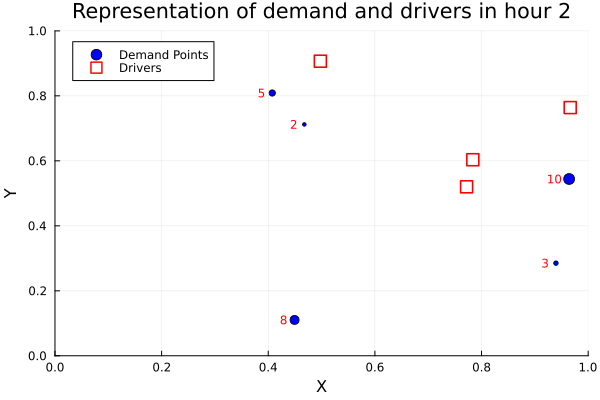

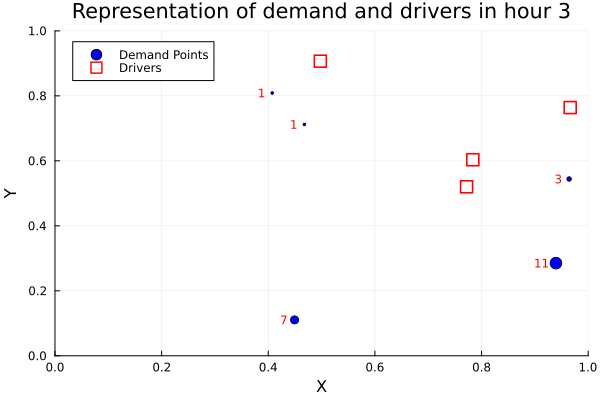

In [10]:
using Plots

# Number of plots (3 different sets of demand locations)
n_plots = 3

# Plotting the 3 graphs
for i in 1:n_plots
    # Select the corresponding 5 tuples for the current plot
    current_tuples = tuples[(i-1)*5 + 1:i*5]

    # Extract the x_c, y_c values (demand locations)
    x_c = [t[1] for t in current_tuples]
    y_c = [t[2] for t in current_tuples]
    d = [t[3] for t in current_tuples]  # demand values
    
    # Create the scatter plot for demand points
    p = scatter(
        x_c, y_c;
        label = "Demand Points",
        markershape = :circle,
        markercolor = :blue,
        markersize = 0.5 .* (2 .+ d),
        title = "Representation of demand and drivers in hour $(i)",
        xlabel = "X",
        ylabel = "Y",
        xlims = (0, 1),
        ylims = (0, 1)
    )
    
    # Annotate each demand point slightly to the left with red text
    for (xi, yi, di) in zip(x_c, y_c, d)
        annotate!(p, xi - 0.015, yi, text(string(di), 8, :red, :right))
    end
    
    # Add the driver points (constant across plots)
    scatter!(p,
        x_f, y_f;
        label = "Drivers",
        markershape = :rect,
        markercolor = :white,
        markersize = 6,
        markerstrokecolor = :red,
        markerstrokewidth = 2
    )

    # Display the plot
    display(p)
end


> Hour 1's model!

In [11]:
# Start the model
model = Model(Mosek.Optimizer)
n = 4 # Number of drivers
k = 24 # Number of hours in the day
l = 5 #number of hotspots


# Productivity & energy of drivers
pr = [6 8 4 2]                                   # Still can randomize this OR draw from normal dist
fixed_c = [2]

# Variables
@variable(model, y[1:n, 1:l], Bin)

# Constraints
for j in 1:l
    @constraint(model, sum(y[i,j]*pr[i] for i in 1:n) >= tuples[j][3]) # Tuples is a vector that has  tuples that contains the x_coord,
                                                                       # y_coord and the demand
end

# Objective
@objective(model, Min,                             
    sum(y[i,j]*fixed_c[1] for i in 1:n, j in 1:l) + # Fixed component
    sum(y[i,j] * c[j,i] for i in 1:n, j in 1:l)     # Variable component based on distance
    )

print(model)

In [12]:
optimize!(model)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : LO (linear optimization problem)
  Constraints            : 25              
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 20              
  Matrix variables       : 0               
  Integer variables      : 20              

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 0.00, probing time =  0.00
Presolved problem: 20 variables, 5 constraints, 20 non-zeros
Presolved problem: 0 general integer, 20 binary, 0 continuous
Clique table size: 2
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        0        1        0        1.2159820113e+01     NA                   NA          0.0   
0        1        1        0        1.2085686655e+01   

In [13]:
value.(y)

4×5 Matrix{Float64}:
 -0.0   1.0  -0.0  -0.0   1.0
 -0.0  -0.0   1.0   1.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0
  1.0  -0.0  -0.0  -0.0  -0.0

In [14]:
objective_value(model)

12.085686655136078

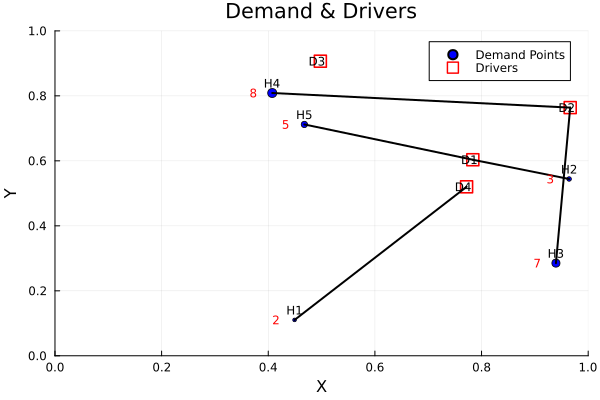

In [15]:
using Plots

# (Assume you’ve already done optimize!(model) and have y_val, x_f, y_f, tuples, etc.)

n_plots = 1
y_val   = value.(y)   # optimized assignments

for plot_idx in 1:n_plots
    current = tuples[(plot_idx-1)*5 + 1 : plot_idx*5]
    x_c = [t[1] for t in current]
    y_c = [t[2] for t in current]
    d   = [t[3] for t in current]

    # 1) Demand points (blue circles, one legend entry)
    p = scatter(
        x_c, y_c;
        label       = "Demand Points",
        markershape = :circle,
        markercolor = :blue,
        markersize  = 0.5 .* (2 .+ d),
        title       = "Demand & Drivers",
        xlabel      = "X", ylabel = "Y",
        xlims       = (0,1), ylims = (0,1),
        legend      = :topright,
        legendfontsize = 8
    )

    # 2) Label each hotspot above the circle
    for (xi, yi, idx) in zip(x_c, y_c, 1:length(x_c))
        annotate!(
            p,
            xi, yi + 0.03,
            text("H$(idx)", 8, :black, :center);
            label = ""
        )
    end

    # 3) Annotate numeric demand to the left in red
    for (xi, yi, di) in zip(x_c, y_c, d)
        annotate!(
            p,
            xi - 0.03, yi,
            text(string(di), 8, :red, :right);
            label = ""
        )
    end

    # 4) All drivers (white squares with red stroke)
    scatter!(
        p,
        x_f, y_f;
        label            = "Drivers",
        markershape      = :rect,
        markercolor      = :white,
        markersize       = 6,
        markerstrokecolor = :red,
        markerstrokewidth = 2
    )

    # 5) Label each driver “D1”, “D2”, …
    for (xi, yi, idx) in zip(x_f, y_f, 1:n)
        annotate!(
            p,
            xi - 0.02, yi,
            text("D$(idx)", 8, :black, :left);
            label = ""
        )
    end

    # 6) Draw assignment lines for each y[i,j] == 1
    for j in 1:l, i in 1:n
        if y_val[i,j] == 1
            plot!(
                p,
                [x_c[j], x_f[i]],
                [y_c[j], y_f[i]];
                color     = :black,
                label     = "",
                linewidth = 2
            )
        end
    end

    display(p)
end


> Hour 2!

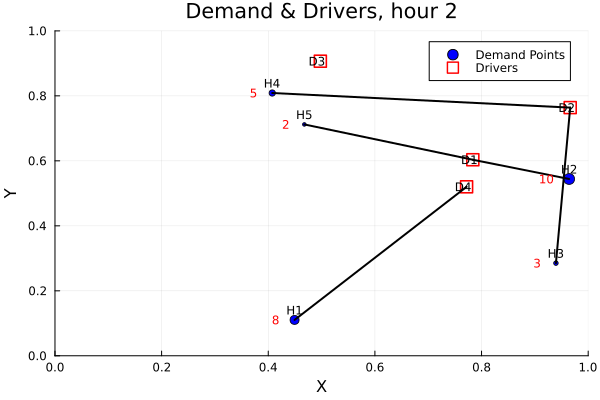

In [16]:
using Plots

# (Assume you’ve already done optimize!(model) and have y_val, x_f, y_f, tuples, etc.)

n_plots = 1
y_val   = value.(y)   # optimized assignments

for plot_idx in 1:n_plots
    current = tuples[5 + 1 : plot_idx*10]
    x_c = [t[1] for t in current]
    y_c = [t[2] for t in current]
    d   = [t[3] for t in current]

    # 1) Demand points (blue circles, one legend entry)
    p = scatter(
        x_c, y_c;
        label       = "Demand Points",
        markershape = :circle,
        markercolor = :blue,
        markersize  = 0.5 .* (2 .+ d),
        title       = "Demand & Drivers, hour 2",
        xlabel      = "X", ylabel = "Y",
        xlims       = (0,1), ylims = (0,1),
        legend      = :topright,
        legendfontsize = 8
    )

    # 2) Label each hotspot above the circle
    for (xi, yi, idx) in zip(x_c, y_c, 1:length(x_c))
        annotate!(
            p,
            xi, yi + 0.03,
            text("H$(idx)", 8, :black, :center);
            label = ""
        )
    end

    # 3) Annotate numeric demand to the left in red
    for (xi, yi, di) in zip(x_c, y_c, d)
        annotate!(
            p,
            xi - 0.03, yi,
            text(string(di), 8, :red, :right);
            label = ""
        )
    end

    # 4) All drivers (white squares with red stroke)
    scatter!(
        p,
        x_f, y_f;
        label            = "Drivers",
        markershape      = :rect,
        markercolor      = :white,
        markersize       = 6,
        markerstrokecolor = :red,
        markerstrokewidth = 2
    )

    # 5) Label each driver “D1”, “D2”, …
    for (xi, yi, idx) in zip(x_f, y_f, 1:n)
        annotate!(
            p,
            xi - 0.02, yi,
            text("D$(idx)", 8, :black, :left);
            label = ""
        )
    end

    # 6) Draw assignment lines for each y[i,j] == 1
    for j in 1:l, i in 1:n
        if y_val[i,j] == 1
            plot!(
                p,
                [x_c[j], x_f[i]],
                [y_c[j], y_f[i]];
                color     = :black,
                label     = "",
                linewidth = 2
            )
        end
    end

    display(p)
end


> Hour 3!

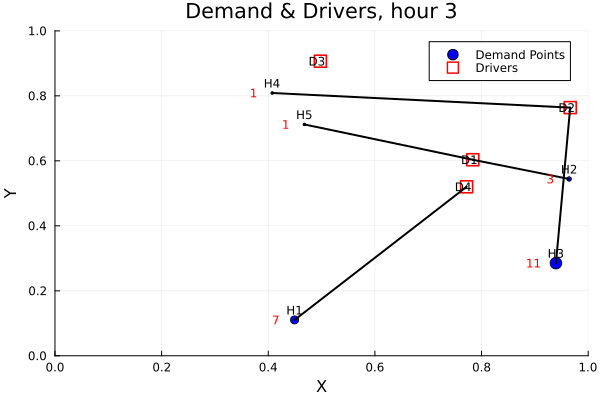

In [17]:
using Plots

# (Assume you’ve already done optimize!(model) and have y_val, x_f, y_f, tuples, etc.)

n_plots = 1
y_val   = value.(y)   # optimized assignments

for plot_idx in 1:n_plots
    current = tuples[10 + 1 : plot_idx*15]
    x_c = [t[1] for t in current]
    y_c = [t[2] for t in current]
    d   = [t[3] for t in current]

    # 1) Demand points (blue circles, one legend entry)
    p = scatter(
        x_c, y_c;
        label       = "Demand Points",
        markershape = :circle,
        markercolor = :blue,
        markersize  = 0.5 .* (2 .+ d),
        title       = "Demand & Drivers, hour 3",
        xlabel      = "X", ylabel = "Y",
        xlims       = (0,1), ylims = (0,1),
        legend      = :topright,
        legendfontsize = 8
    )

    # 2) Label each hotspot above the circle
    for (xi, yi, idx) in zip(x_c, y_c, 1:length(x_c))
        annotate!(
            p,
            xi, yi + 0.03,
            text("H$(idx)", 8, :black, :center);
            label = ""
        )
    end

    # 3) Annotate numeric demand to the left in red
    for (xi, yi, di) in zip(x_c, y_c, d)
        annotate!(
            p,
            xi - 0.03, yi,
            text(string(di), 8, :red, :right);
            label = ""
        )
    end

    # 4) All drivers (white squares with red stroke)
    scatter!(
        p,
        x_f, y_f;
        label            = "Drivers",
        markershape      = :rect,
        markercolor      = :white,
        markersize       = 6,
        markerstrokecolor = :red,
        markerstrokewidth = 2
    )

    # 5) Label each driver “D1”, “D2”, …
    for (xi, yi, idx) in zip(x_f, y_f, 1:n)
        annotate!(
            p,
            xi - 0.02, yi,
            text("D$(idx)", 8, :black, :left);
            label = ""
        )
    end

    # 6) Draw assignment lines for each y[i,j] == 1
    for j in 1:l, i in 1:n
        if y_val[i,j] == 1
            plot!(
                p,
                [x_c[j], x_f[i]],
                [y_c[j], y_f[i]];
                color     = :black,
                label     = "",
                linewidth = 2
            )
        end
    end

    display(p)
end
